In [1]:
import os
from tqdm.notebook import tqdm
import random
import warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable TF Warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

In [3]:
import cv2

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

In [5]:
sns.set(style='darkgrid', palette='deep')

tf.random.set_seed(42)

# Exploratory Data Analysis

In [6]:
# Count the number of images in each class
class_counts = {}
for subdir, _, files in os.walk('Vegetable Images/train/'):
    if subdir.split("/")[-1] != "":
        class_counts[subdir.split("/")[-1]] = len(files)

# Plot class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Vegetable Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

* Imbalanced Dataset
* Will have to via adjusting class weights, penalising the model more for incorrect classification of lower frequency class

In [7]:
plt.figure(figsize=(12, 8))
for i in range(15):
    subdir = os.listdir('Vegetable Images/train/')[i]
    img_file = random.choice(os.listdir(os.path.join('Vegetable Images/train/', subdir)))
    img_path = os.path.join('Vegetable Images/train', subdir, img_file)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    plt.subplot(3, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(subdir)
    plt.axis('off')
plt.show()

In [8]:
def plot_intensity_histogram(image_path, class_name, ax):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    ax.hist(img.ravel())
    ax.set_xlabel('Pixel Intensity')
    ax.set_title(f'Class: {class_name}')
    return ax

fig, axes = plt.subplots(3, 5, figsize=(15, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

class_folders = os.listdir('Vegetable Images/train/')
for i, class_folder in enumerate(class_folders):
    sample_image_path = os.path.join('Vegetable Images/train/', class_folder, os.listdir(f'Vegetable Images/train/{class_folder}')[0])
    row = i // 5
    col = i % 5
    ax = plot_intensity_histogram(sample_image_path, class_folder, axes[row, col])
    if col == 0:
        ax.set_ylabel('Frequency')

plt.show()

In [9]:
class_keys = {
    "Bean": 0,
    "Bitter_Gourd": 1,
    "Bottle_Gourd": 2,
    "Brinjal": 3,
    "Broccoli": 4,
    "Cabbage": 5,
    "Capsicum": 6,
    "Carrot": 7,
    "Cauliflower": 8,
    "Cucumber": 9,
    "Papaya": 10,
    "Potato": 11,
    "Pumpkin": 12,
    "Radish": 13,
    "Tomato": 14
}

In [10]:
def load_images(folder_path, image_size):
    images = []
    labels = []
    counter = 0
    for subdir, _, files in os.walk(folder_path):
        for file in tqdm(files, desc=subdir):
            img_path = os.path.join(subdir, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img.shape != (image_size, image_size):
                img = cv2.resize(img, (image_size, image_size))
            images.append(img)
            labels.append(class_keys[subdir.split("/")[-1]])
            counter += 1
    
    images = np.array(images).reshape(-1, image_size, image_size, 1)
    return images, to_categorical(np.array(labels), 15)

def resize_images(image_arr, image_size):
    image_arr = [cv2.resize(img, (image_size, image_size)) for img in image_arr]
    return np.array(image_arr).reshape(-1, image_size, image_size, 1)

train_images, train_labels = load_images('Vegetable Images/train/', 224)
test_images, test_labels = load_images('Vegetable Images/test/', 224)
val_images, val_labels = load_images('Vegetable Images/validation/', 224)

# small_train_images = resize_images(train_images, 31)
# small_test_images = resize_images(test_images, 31)
# small_val_images = resize_images(val_images, 31)


Vegetable Images/train/: 0it [00:00, ?it/s]

Vegetable Images/train/Bean:   0%|          | 0/780 [00:00<?, ?it/s]

Vegetable Images/train/Bitter_Gourd:   0%|          | 0/720 [00:00<?, ?it/s]

Vegetable Images/train/Bottle_Gourd:   0%|          | 0/441 [00:00<?, ?it/s]

Vegetable Images/train/Brinjal:   0%|          | 0/868 [00:00<?, ?it/s]

Vegetable Images/train/Broccoli:   0%|          | 0/750 [00:00<?, ?it/s]

Vegetable Images/train/Cabbage:   0%|          | 0/503 [00:00<?, ?it/s]

Vegetable Images/train/Capsicum:   0%|          | 0/351 [00:00<?, ?it/s]

Vegetable Images/train/Carrot:   0%|          | 0/256 [00:00<?, ?it/s]

Vegetable Images/train/Cauliflower:   0%|          | 0/587 [00:00<?, ?it/s]

Vegetable Images/train/Cucumber:   0%|          | 0/812 [00:00<?, ?it/s]

Vegetable Images/train/Papaya:   0%|          | 0/566 [00:00<?, ?it/s]

Vegetable Images/train/Potato:   0%|          | 0/377 [00:00<?, ?it/s]

Vegetable Images/train/Pumpkin:   0%|          | 0/814 [00:00<?, ?it/s]

Vegetable Images/train/Radish:   0%|          | 0/248 [00:00<?, ?it/s]

Vegetable Images/train/Tomato:   0%|          | 0/955 [00:00<?, ?it/s]

Vegetable Images/test/: 0it [00:00, ?it/s]

Vegetable Images/test/Bean:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/test/Bitter_Gourd:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/test/Bottle_Gourd:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/test/Brinjal:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/test/Broccoli:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/test/Cabbage:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/test/Capsicum:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/test/Carrot:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/test/Cauliflower:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/test/Cucumber:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/test/Papaya:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/test/Potato:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/test/Pumpkin:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/test/Radish:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/test/Tomato:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/: 0it [00:00, ?it/s]

Vegetable Images/validation/Bean:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/Bitter_Gourd:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/Bottle_Gourd:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/Brinjal:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/Broccoli:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/Cabbage:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/Capsicum:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/Carrot:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/Cauliflower:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/Cucumber:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/Papaya:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/Potato:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/Pumpkin:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/Radish:   0%|          | 0/200 [00:00<?, ?it/s]

Vegetable Images/validation/Tomato:   0%|          | 0/200 [00:00<?, ?it/s]

## Preprocessing: Data Augmentation 
#### Reasoning:
* Data augmentation effectively increases the size of the training dataset. With more diverse examples, the model can learn a broader range of patterns and become more robust. Especially with some classes only having about 200 training samples.
* Model will be more generalized and reduces overfitting from memorizing specific examples.

In [411]:
from keras.layers import RandomCrop, RandomContrast, RandomFlip, RandomRotation, RandomTranslation, RandomZoom, Resizing

# extremely slow in TF 2.10.0, can slow model as much as 6x

image_augmentation = Sequential(
    [
        RandomFlip("horizontal_and_vertical"),
#         RandomContrast(0.5),
#         RandomRotation(1),
#         RandomZoom(0.5, 0.5)
    ]
)

resize_small = Resizing(31, 31)
resize_large = Resizing(128, 128)

In [253]:
resize_small(ImageAugmentationLayer(input_shape=(224, 224))(train_images[i])).shape

TensorShape([31, 31, 1])

In [374]:
class ImageAugmentationLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ImageAugmentationLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        super(ImageAugmentationLayer, self).build(input_shape)
    
    def zoom_scale(self, angle):
        from numpy import pi, cos, sin
        angle = abs(angle)
        angle *= pi / 180
        return cos(angle) + sin(angle)

    def zoom_at(self, img, angle=0):
        from numpy import array
        cy, cx = [x/2 for x in img.shape][:2]
        rot_mat = cv2.getRotationMatrix2D((cx, cy), angle, self.zoom_scale(angle))
        result = cv2.warpAffine(array(img), rot_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR)
        return result

    def call(self, inputs, training=True):
        from numpy import expand_dims
        if training:
            output = []
            for img in inputs:
                # Randomly adjust contrast
                img = tf.expand_dims(img, axis=-1)
                img = tf.image.random_contrast(img, lower=0.5, upper=1.5)

                # Randomly flip the image horizontally
                img = tf.image.random_flip_left_right(img)

                # Randomly rotate the image between -45 and 45 degrees
                angle = random.randint(-45, 45)
                img = self.zoom_at(img, angle)

                # Add a channel dimension
                img = expand_dims(img, axis=-1)

                # Randomly zoom into the image
                zoom_factor = random.uniform(0.9, 1.1)
                img = tf.keras.preprocessing.image.random_zoom(img, (0.9, 1.1))
                output.append(img)
            return output
        else:
            return inputs


In [388]:
import tensorflow as tf

class ImageAugmentationLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ImageAugmentationLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        super(ImageAugmentationLayer, self).build(input_shape)
    
    def zoom_scale(self, angle):
        angle = tf.abs(angle)
        angle *= tf.constant(3.141592653589793 / 180)  # Convert angle to radians
        return tf.math.cos(angle) + tf.math.sin(angle)
    
    def zoom_at(self, img, angle=0):
        
        # Compute center of the image using eager execution
        cy, cx = tf.divide(tf.shape(img)[1:3], 2)

        # Rotate the image using tf.raw_ops.MatrixRotate (same as before)
        rot_mat = tf.raw_ops.MatrixRotate(rotation_angle=tf.constant(angle, dtype=tf.float32),
                                          num_angles=1,
                                          input=tf.reshape(tf.concat([cx, cy], axis=0), (1, 2)),
                                          T=tf.float32)
        result = tf.raw_ops.ImageProjectiveTransformV2(images=tf.expand_dims(img, axis=0),
                                                       transforms=rot_mat,
                                                       output_shape=tf.shape(img)[1:3])
        return tf.squeeze(result, axis=0)

    def call(self, inputs, training=True):
        if training:
            output = []
            for img in inputs:
                # Add a channel dimension
                img = tf.expand_dims(img, axis=-1)

                # Randomly adjust contrast
                img = tf.image.random_contrast(img, lower=0.5, upper=1.5)

                # Randomly flip the image horizontally
                img = tf.image.random_flip_left_right(img)

                # Randomly rotate the image between -45 and 45 degrees
                angle = tf.random.uniform(shape=[], minval=-45, maxval=45, dtype=tf.float32)
                img = self.zoom_at(img, angle)

                # Randomly zoom into the image
                zoom_factor = tf.random.uniform(shape=[], minval=0.9, maxval=1.1, dtype=tf.float32)
                img = tf.image.central_crop(img, central_fraction=zoom_factor)

                output.append(img)
            return output
        else:
            return inputs


In [390]:
class CustomImageAugmentationLayer(tf.keras.layers.Layer):
    def __init__(self, contrast_range=(0.2, 1.8), flip_mode='horizontal_and_vertical', rotation_range=45, **kwargs):
        super(CustomImageAugmentationLayer, self).__init__(**kwargs)
        self.contrast_range = contrast_range
        self.flip_mode = flip_mode
        self.rotation_range = rotation_range

    def call(self, inputs, training=True):
        if training:
            # Random Contrast
            contrast_factor = tf.random.uniform(shape=[], minval=self.contrast_range[0], maxval=self.contrast_range[1])
            inputs = tf.image.adjust_contrast(inputs, contrast_factor)

            # Random Flipping
            if self.flip_mode == 'horizontal':
                inputs = tf.image.random_flip_left_right(inputs)
            elif self.flip_mode == 'vertical':
                inputs = tf.image.random_flip_up_down(inputs)
            elif self.flip_mode == 'horizontal_and_vertical':
                inputs = tf.image.random_flip_left_right(inputs)
                inputs = tf.image.random_flip_up_down(inputs)

            # Random Rotation
            rotation_angle = tf.random.uniform(shape=[], minval=-self.rotation_range, maxval=self.rotation_range)
            inputs = tf.image.rot90(inputs, k=rotation_angle // 90)

        return inputs

    def get_config(self):
        config = super(CustomImageAugmentationLayer, self).get_config()
        config.update({
            'contrast_range': self.contrast_range,
            'flip_mode': self.flip_mode,
            'rotation_range': self.rotation_range,
        })
        return config

UnknownError: Exception encountered when calling layer "custom_image_augmentation_layer_1" "                 f"(type CustomImageAugmentationLayer).

{{function_node __wrapped__Sub_device_/job:localhost/replica:0/task:0/device:GPU:0}} JIT compilation failed. [Op:Sub]

Call arguments received by layer "custom_image_augmentation_layer_1" "                 f"(type CustomImageAugmentationLayer):
  • inputs=tf.Tensor(shape=(5, 224, 224, 1), dtype=uint8)
  • training=True

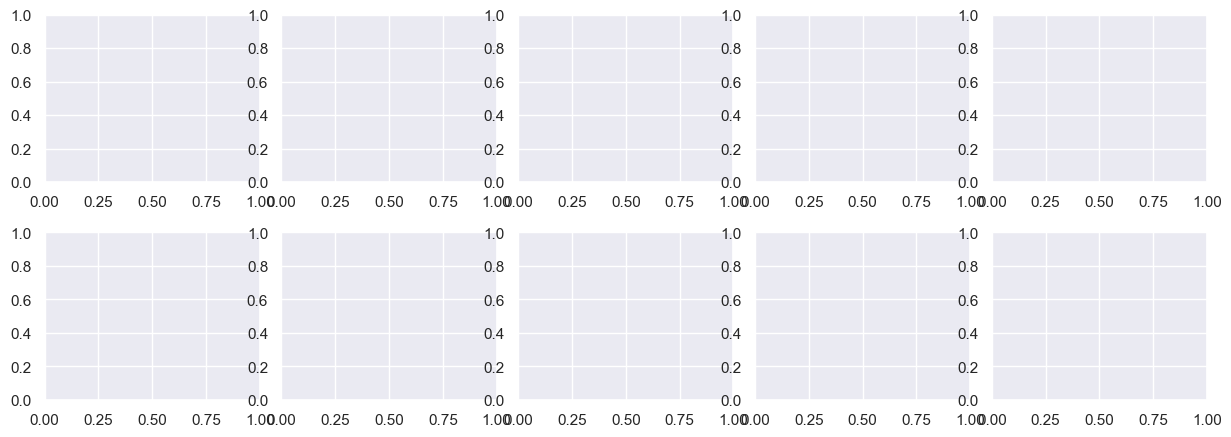

In [392]:
fig, axes = plt.subplots(2, 5, figsize=(15, 5))

# axes = np.flatten(axes)
plt.subplots_adjust(hspace=0.3, wspace=0.1)
img_aug = CustomImageAugmentationLayer()

augmented = img_aug(train_images[:5], training=True)

for i in range(5):
    axes[0][i].imshow(train_images[i], cmap="gray")
    axes[1][i].imshow(augmented[i], cmap="gray")
    
    
axes[0][2].set_title("Original Images")
axes[1][2].set_title("Augmented Images")
    
plt.show()

This data augmentation is added as a preprocessing layer in the model and applied during model training.

### Calculating Class Weights

In [150]:
from sklearn.utils.class_weight import compute_class_weight

class_series = np.argmax(train_labels, axis=1)
class_labels = np.unique(class_series)
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
class_weights = dict(zip(class_labels, class_weights))
print(class_weights)

{0: 0.7716239316239316, 1: 0.835925925925926, 2: 1.3647770219198792, 3: 0.693394777265745, 4: 0.8024888888888889, 5: 1.1965540092776674, 6: 1.7147198480531813, 7: 2.3510416666666667, 8: 1.0253265190232823, 9: 0.7412151067323481, 10: 1.0633686690223794, 11: 1.5964633068081344, 12: 0.7393939393939394, 13: 2.4268817204301074, 14: 0.6302268760907505}


Classes with the lowest sample count in the training set will have the greatest weight eg. 13: Radish

In [412]:
model_small = Sequential([
    image_augmentation,
    resize_small,
    Conv2D(32, (3, 3), activation='relu', input_shape=(31, 31, 1)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(400, activation='relu'),
    Dense(400, activation='relu'),
    Dense(15, activation='softmax')
])

# Compile the model
model_small.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model for small images
history = model_small.fit(train_images, train_labels, epochs=10, batch_size=50, validation_data=(val_images, val_labels))

small_accuracy = model_small.evaluate(test_images, test_labels, verbose=0)[1]

print(f"Accuracy for small images (31x31): {small_accuracy:.2f}")

Epoch 1/10
181/181 [==============================] - 3s 13ms/step - loss: 2.6093 - accuracy: 0.2045 - val_loss: 2.2431 - val_accuracy: 0.2673
Epoch 2/10
181/181 [==============================] - 2s 12ms/step - loss: 1.8496 - accuracy: 0.4045 - val_loss: 1.8314 - val_accuracy: 0.4040
Epoch 3/10
181/181 [==============================] - 2s 12ms/step - loss: 1.4330 - accuracy: 0.5294 - val_loss: 1.4602 - val_accuracy: 0.5120
Epoch 4/10
181/181 [==============================] - 2s 13ms/step - loss: 1.1126 - accuracy: 0.6369 - val_loss: 1.5158 - val_accuracy: 0.5043
Epoch 5/10
181/181 [==============================] - 2s 13ms/step - loss: 0.8679 - accuracy: 0.7143 - val_loss: 1.6206 - val_accuracy: 0.5127
Epoch 6/10
181/181 [==============================] - 2s 14ms/step - loss: 0.6881 - accuracy: 0.7781 - val_loss: 1.1342 - val_accuracy: 0.6547
Epoch 7/10
181/181 [==============================] - 2s 13ms/step - loss: 0.5158 - accuracy: 0.8333 - val_loss: 1.0565 - val_accuracy: 0.6993

In [19]:
model_small = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(31, 31, 1), kernel_regularizer=l2(0.01)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(400, activation='relu'),
    Dense(400, activation='relu'),
    Dense(15, activation='softmax')
])

# Compile the model
model_small.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model for small images
history = model_small.fit(small_train_images, small_train_labels, epochs=10, batch_size=50, validation_data=(small_val_images, small_val_labels))

small_accuracy = model_small.evaluate(small_test_images, small_test_labels, verbose=0)[1]

print(f"Accuracy for small images (31x31): {small_accuracy:.2f}")

NameError: name 'small_train_labels' is not defined

In [413]:
history.history

{'loss': [2.6093130111694336,
  1.8496383428573608,
  1.432969570159912,
  1.1125555038452148,
  0.8679344058036804,
  0.6881312727928162,
  0.5158091187477112,
  0.39920979738235474,
  0.3568345606327057,
  0.2747693955898285],
 'accuracy': [0.20447497069835663,
  0.404519259929657,
  0.529353141784668,
  0.6369073987007141,
  0.714333176612854,
  0.7781347036361694,
  0.8332964181900024,
  0.8673017024993896,
  0.8836951851844788,
  0.9110544919967651],
 'val_loss': [2.243149995803833,
  1.8313723802566528,
  1.4601783752441406,
  1.5157898664474487,
  1.620621919631958,
  1.1341984272003174,
  1.056510090827942,
  0.9788655638694763,
  0.9810826778411865,
  1.1725965738296509],
 'val_accuracy': [0.26733332872390747,
  0.40400001406669617,
  0.5120000243186951,
  0.5043333172798157,
  0.512666642665863,
  0.6546666622161865,
  0.6993333101272583,
  0.7213333249092102,
  0.7350000143051147,
  0.7089999914169312]}

In [ ]:

    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),

In [ ]:
# Create the neural network model for small images
fast_model_small = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(31, 31, 1)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(400, activation='relu'),
    Dense(400, activation='relu'),
    Dense(15, activation='softmax')
])

In [414]:
model_small.summary()

Model: "sequential_85"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_84 (Sequential)  (None, 224, 224, 1)       0         
                                                                 
 resizing_21 (Resizing)      (None, 31, 31, 1)         0         
                                                                 
 conv2d_100 (Conv2D)         (None, 29, 29, 32)        320       
                                                                 
 conv2d_101 (Conv2D)         (None, 27, 27, 64)        18496     
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_102 (Conv2D)         (None, 11, 11, 64)        36928     
                                                     